# Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As a Data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes.

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score,log_loss
import xgboost as xgb

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

import time

import warnings
warnings.simplefilter("ignore")

In [2]:
data = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv")

data.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


- Removing the unwanted column Unnamed: 0

In [3]:
data.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
data.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [5]:
data.shape

(19104, 13)

In [6]:
data.nunique()

,0
MMM-YY,24
Driver_ID,2381
Age,36
Gender,2
City,29
Education_Level,3
Income,2383
Dateofjoining,869
LastWorkingDate,493
Joining Designation,5


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


# Converting features to respective data-types

In [8]:
data["MMM-YY"] = pd.to_datetime(data["MMM-YY"])
data["Dateofjoining"] = pd.to_datetime(data["Dateofjoining"])
data["LastWorkingDate"] = pd.to_datetime(data["LastWorkingDate"])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

# Check for missing values

In [10]:
data.isnull().sum() / len(data) * 100

,0
MMM-YY,0.000000
Driver_ID,0.000000
Age,0.319305
Gender,0.272194
City,0.000000
Education_Level,0.000000
Income,0.000000
Dateofjoining,0.000000
LastWorkingDate,91.541039
Joining Designation,0.000000


- There are missing values found in `AGE`, `Gender`
- `LastWorkingDate` feature contains missing values which indicates the driver has not left the company yet.

In [11]:
num_vars = data.select_dtypes(np.number)

num_vars.columns

Index(['Driver_ID', 'Age', 'Gender', 'Education_Level', 'Income',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [12]:
num_vars.drop(["Driver_ID"], axis = 1, inplace = True)

In [13]:
_ = data.select_dtypes(np.number)
_.isnull().sum()

,0
Driver_ID,0
Age,61
Gender,52
Education_Level,0
Income,0
Joining Designation,0
Grade,0
Total Business Value,0
Quarterly Rating,0


In [14]:
null_rows = _.loc[_['Age'].isnull() | _['Gender'].isnull()]

In [15]:
driver_id_with_nulls = list(null_rows["Driver_ID"])

In [16]:
# filter rows based on list values
mask = _['Driver_ID'].isin(driver_id_with_nulls)
driver = pd.DataFrame(_[mask])

In [17]:
pd.set_option("display.max_rows", None)

In [19]:
# Makes sense to do KNN imputation can handle missing values where driver's historic data is present
# and can handle driver having one record only or multiple records but column is missing for all

# KNN Imputation

In [20]:
imputer = KNNImputer(n_neighbors=1, metric='nan_euclidean')
imputer.fit(num_vars)
data_new = imputer.transform(num_vars)

In [21]:
data_new = pd.DataFrame(data_new)

In [22]:
data_new.columns = num_vars.columns

In [23]:
data_new.isnull().sum()

,0
Age,0
Gender,0
Education_Level,0
Income,0
Joining Designation,0
Grade,0
Total Business Value,0
Quarterly Rating,0


- We have successfully imputed the missing values using KNNImputer

In [24]:
data_new.nunique()

,0
Age,36
Gender,2
Education_Level,3
Income,2383
Joining Designation,5
Grade,5
Total Business Value,10181
Quarterly Rating,4


In [25]:
data_new['Gender'].value_counts()

,count
Gender,
0.0,11105
1.0,7999


# Retrieving the Non Numeric columns back

In [26]:
resultant_columns = list(set(data.columns).difference(set(num_vars)))

resultant_columns

['Driver_ID', 'MMM-YY', 'City', 'Dateofjoining', 'LastWorkingDate']

In [27]:
new_df = pd.concat([data_new, data[resultant_columns]], axis=1)

new_df.shape

(19104, 13)

In [28]:
new_df.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Driver_ID,MMM-YY,City,Dateofjoining,LastWorkingDate
0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0,1,2019-01-01,C23,2018-12-24,NaT
1,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0,1,2019-02-01,C23,2018-12-24,NaT
2,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0,1,2019-03-01,C23,2018-12-24,2019-03-11
3,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2,2020-11-01,C7,2020-11-06,NaT
4,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2,2020-12-01,C7,2020-11-06,NaT


# Data Preprocessing

In [29]:
agg_functions = {
    "Age": "max",
    "Gender": lambda x: x.mode().iloc[0],  # Take the first mode if multiple exist
    "Education_Level": "last",
    "Income": "last",
    "Joining Designation": "last",
    "Grade": "last",
    "Total Business Value": "sum",
    "Quarterly Rating": "last",
    "LastWorkingDate": "last",
    "City": "first",
    "Dateofjoining": "last"
}

processed_df = new_df.groupby(["Driver_ID", "MMM-YY"]).aggregate(agg_functions).sort_index(ascending=[True, True])

processed_df.head()


Age  Gender  Education_Level   Income  \
Driver_ID MMM-YY                                               
1         2019-01-01  28.0     0.0              2.0  57387.0   
          2019-02-01  28.0     0.0              2.0  57387.0   
          2019-03-01  28.0     0.0              2.0  57387.0   
2         2020-11-01  31.0     0.0              2.0  67016.0   
          2020-12-01  31.0     0.0              2.0  67016.0   

                      Joining Designation  Grade  Total Business Value  \
Driver_ID MMM-YY                                                         
1         2019-01-01                  1.0    1.0             2381060.0   
          2019-02-01                  1.0    1.0             -665480.0   
          2019-03-01                  1.0    1.0                   0.0   
2         2020-11-01                  2.0    2.0                   0.0   
          2020-12-01                  2.0    2.0                   0.0   

                      Quarterly Rating LastWorkingDate City Dateofjoining  
Driver_ID MMM-YY                                                           
1         2019-01-01               2.0             NaT  C23    2018-12-24  
          2019-02-01               2.0             NaT  C23    2018-12-24  
          2019-03-01               2.0      2019-03-11  C23    2018-12-24  
2         2020-11-01               1.0             NaT   C7    2020-11-06  
          2020-12-01               1.0             NaT   C7    2020-11-06

In [30]:
final_data = pd.DataFrame()

In [31]:
final_data["Driver_ID"] = new_df["Driver_ID"].unique()

In [32]:
final_data['Age'] = list(processed_df.groupby('Driver_ID',axis=0).max('MMM-YY')['Age'])
final_data['Gender'] = list(processed_df.groupby('Driver_ID').agg({'Gender':'last'})['Gender'])
final_data['City'] = list(processed_df.groupby('Driver_ID').agg({'City':'last'})['City'])
final_data['Education'] = list(processed_df.groupby('Driver_ID').agg({'Education_Level':'last'})['Education_Level'])
final_data['Income'] = list(processed_df.groupby('Driver_ID').agg({'Income':'last'})['Income'])
final_data['Joining_Designation'] = list(processed_df.groupby('Driver_ID').agg({'Joining Designation':'last'})['Joining Designation'])
final_data['Grade'] = list(processed_df.groupby('Driver_ID').agg({'Grade':'last'})['Grade'])
final_data['Total_Business_Value'] = list(processed_df.groupby('Driver_ID',axis=0).sum('Total Business Value')['Total Business Value'])
final_data['Last_Quarterly_Rating'] = list(processed_df.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating'])

In [33]:
final_data.head()

,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0


In [34]:
final_data.shape

(2381, 10)

# Feature Engineering

- Creating a column which tells whether the quarterly rating has increased for that driver - for those whose quarterly rating has increased we assign the value 1 else 0

In [35]:
first_quarter = processed_df.groupby(["Driver_ID"]).agg({"Quarterly Rating": "first"})

last_quarter = processed_df.groupby(["Driver_ID"]).agg({"Quarterly Rating": "last"})

qr = (last_quarter["Quarterly Rating"] > first_quarter["Quarterly Rating"]).reset_index()

empid = qr[qr["Quarterly Rating"] == True]["Driver_ID"]

qrl = []
for i in final_data["Driver_ID"]:
    if i in empid.values:
        qrl.append(1)
    else:
        qrl.append(0)


final_data["Quarterly_Rating_Increased"] = qrl

In [36]:
final_data.head()

,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,1


- Target variable creation: Creating a column called target which tells whether the driver has left the company- driver whose last working day is present will have the value 1, means that if driver has left the company then we are assigning 1 esle 0

In [37]:
lwd = (processed_df.groupby(["Driver_ID"]).agg({"LastWorkingDate": "last"})["LastWorkingDate"].isna()).reset_index()

lwrid = lwd[lwd["LastWorkingDate"] == True]["Driver_ID"]
target = []

for i in final_data["Driver_ID"]:
    if i in lwrid.values:
        target.append(0)
    else:
        target.append(1)

final_data["target"] = target

In [38]:
final_data.head()

,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,target
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,0,1
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,0,1
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,0,1
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,1,0


- Create a column which tells whether the monthly income has increased for that driver - for those whose monthly income has increased we assign the value 1 else 0

In [39]:
# mi --> monthly income
mif = processed_df.groupby(["Driver_ID"]).agg({"Income": "first"})

mil = processed_df.groupby(["Driver_ID"]).agg({"Income": "last"})

mi_inc = (mil["Income"] > mif["Income"]).reset_index()

empid = mi_inc[mi_inc["Income"] == True]["Driver_ID"]
income = []
for i in final_data["Driver_ID"]:
    if i in empid.values:
        income.append(1)
    else:
        income.append(0)

final_data["Salary_Increased"] = income

In [40]:
final_data.head()

,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,target,Salary_Increased
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,0,1,0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,0,0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,0,1,0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,0,1,0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,1,0,0


In [41]:
final_data["Salary_Increased"].value_counts(normalize=True)

,proportion
Salary_Increased,
0,0.98194
1,0.01806


## Inference
- Around 1.8% drivers income have been increased.

# Statistical Summary

In [42]:
final_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,2381.0,1.397559e+03,8.061616e+02,1.0,695.0,1400.0,2100.0,2788.0
Age,2381.0,3.373583e+01,5.958640e+00,21.0,29.0,33.0,37.0,58.0
Gender,2381.0,4.099118e-01,4.919205e-01,0.0,0.0,0.0,1.0,1.0
Education,2381.0,1.007560e+00,8.162900e-01,0.0,0.0,1.0,2.0,2.0
Income,2381.0,5.933416e+04,2.838367e+04,10747.0,39104.0,55315.0,75986.0,188418.0
Joining_Designation,2381.0,1.820244e+00,8.414334e-01,1.0,1.0,2.0,2.0,5.0
Grade,2381.0,2.096598e+00,9.415218e-01,1.0,1.0,2.0,3.0,5.0
Total_Business_Value,2381.0,4.586742e+06,9.127115e+06,-1385530.0,0.0,817680.0,4173650.0,95331060.0
Last_Quarterly_Rating,2381.0,1.427971e+00,8.098389e-01,1.0,1.0,1.0,2.0,4.0
Quarterly_Rating_Increased,2381.0,1.503570e-01,3.574961e-01,0.0,0.0,0.0,0.0,1.0


## Inference
- There are total of 2381 different drivers data.
- Age of drivers range from 21years to 58years.
- 75% drivers monthly income is <= 75986.
- 75% drivers acquired 4173650 as total business values.

In [43]:
final_data.describe(include = 'object')

,City
count,2381
unique,29
top,C20
freq,152


# Inference
- Majority of drivers are coming from C20 city

In [44]:
final_data["Gender"].value_counts()

,count
Gender,
0.0,1405
1.0,976


# Inference
- Majority of drivers are male

In [45]:
final_data["Education"].value_counts()

,count
Education,
2.0,802
1.0,795
0.0,784


# Inference
- Majority of drivers have completed their graduation.

In [46]:
final_data["target"].value_counts()

,count
target,
1,1616
0,765


# Inference
- Out of 2381 drivers 1616 have left the company.

In [47]:
# Roughly 2:1 imbalance
class_weights = {0:2,1:0.8}

In [48]:
n = ['Gender','Education','Joining_Designation','Grade','Last_Quarterly_Rating','Quarterly_Rating_Increased']

for i in n:
    print("------------------------------------------------------------")
    print(final_data[i].value_counts(normalize=True) * 100)

------------------------------------------------------------
Gender
0.0    59.00882
1.0    40.99118
Name: proportion, dtype: float64
------------------------------------------------------------
Education
2.0    33.683326
1.0    33.389332
0.0    32.927341
Name: proportion, dtype: float64
------------------------------------------------------------
Joining_Designation
1.0    43.091138
2.0    34.229315
3.0    20.705586
4.0     1.511970
5.0     0.461991
Name: proportion, dtype: float64
------------------------------------------------------------
Grade
2.0    35.909282
1.0    31.121378
3.0    26.165477
4.0     5.795884
5.0     1.007980
Name: proportion, dtype: float64
------------------------------------------------------------
Last_Quarterly_Rating
1.0    73.246535
2.0    15.203696
3.0     7.055859
4.0     4.493910
Name: proportion, dtype: float64
------------------------------------------------------------
Quarterly_Rating_Increased
0    84.964301
1    15.035699
Name: proportion, dtype: f

# Inference
- 59% of drivers are male while female constitutes around 41%
- 33% of drivers have completed graduation and 12+ education
- 43% of drivers have 1 as joining_designation
- Around 36% of drivers graded as 2
- Around 73% of drivers rated as 1 on last quarter
- Only 15% of drivers rating has been increased on quarterly

# Univariate Analysis

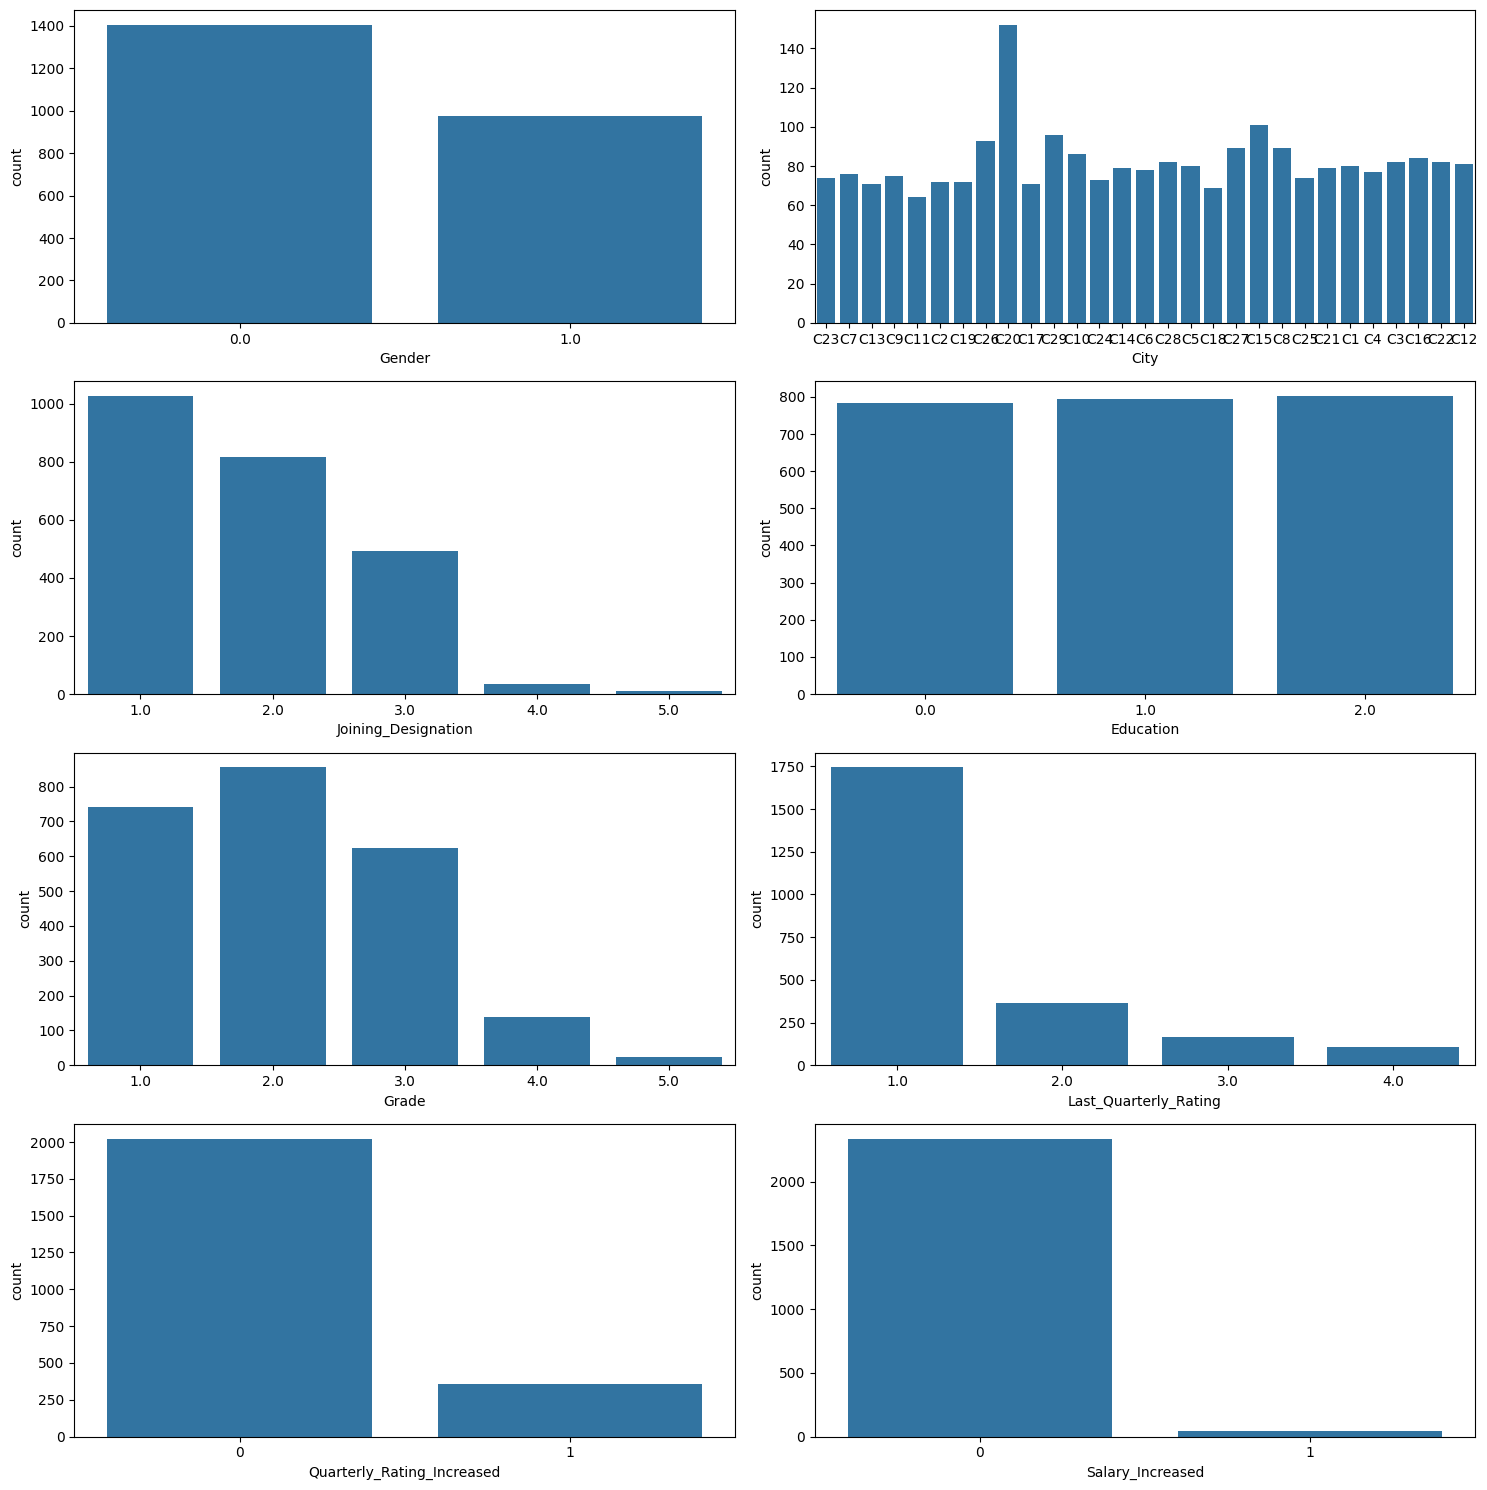

In [49]:
plt.figure(figsize=(15, 15))
plt.subplot(421)
sns.countplot(data=final_data, x="Gender")
# final_data["Gender"].value_counts(normalize=True).plot.bar('Gender')

plt.subplot(422)
sns.countplot(data=final_data, x="City")
plt.xticks(rotation="horizontal")

plt.subplot(423)
sns.countplot(data=final_data, x="Joining_Designation")

plt.subplot(424)
sns.countplot(data=final_data, x="Education")

plt.subplot(425)
sns.countplot(data=final_data, x="Grade")

plt.subplot(426)
sns.countplot(data=final_data, x="Last_Quarterly_Rating")

plt.subplot(427)
sns.countplot(data=final_data, x="Quarterly_Rating_Increased")

plt.subplot(428)
sns.countplot(data=final_data, x="Salary_Increased")

plt.tight_layout()

# Inference
- Out of 2381 employees, 1405 employees are of the Male gender and 976 are females.
- Out of 2381 employees, 152 employees are from city C20 and 101 from city C15.
- Out of 2381 employees, 802 employees have their education as Graduate and 795 have completed their 12.
- Out of 2381 employees, 1026 joined with the grade as 1, 815 employees joined with the grade 2.
- Out of 2381 employees, 855 employees had their designation as 2 at the time of reporting.
- Out of 2381 employees, 1744 employees had their last quarterly rating as 1.
- Out of 2381 employees, the quarterly rating has not increased for 2076 employees.

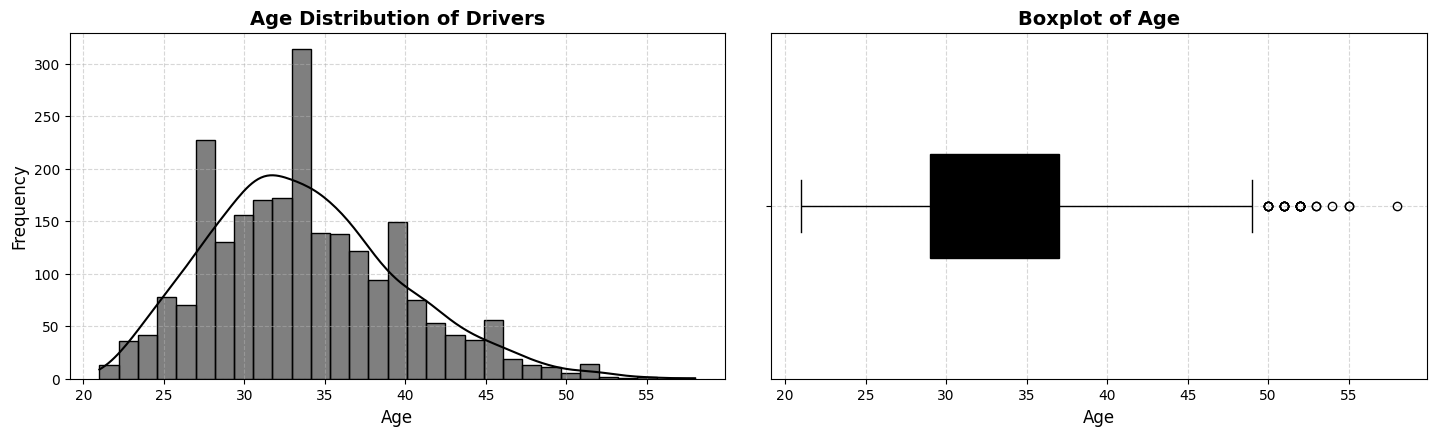

In [50]:
# Set figure size
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram with KDE
sns.histplot(final_data['Age'], color='black', kde=True, ax=axes[0])
axes[0].set_title("Age Distribution of Drivers", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Age", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.5)

# Boxplot
sns.boxplot(x=final_data['Age'], ax=axes[1], color='black', width=0.3)
axes[1].set_title("Boxplot of Age", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Age", fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.5)

# Adjust layout
plt.tight_layout(pad=3)
plt.show()

# Inference
- The distribution of age slightly skewed on right which might indicate the outliers in the data

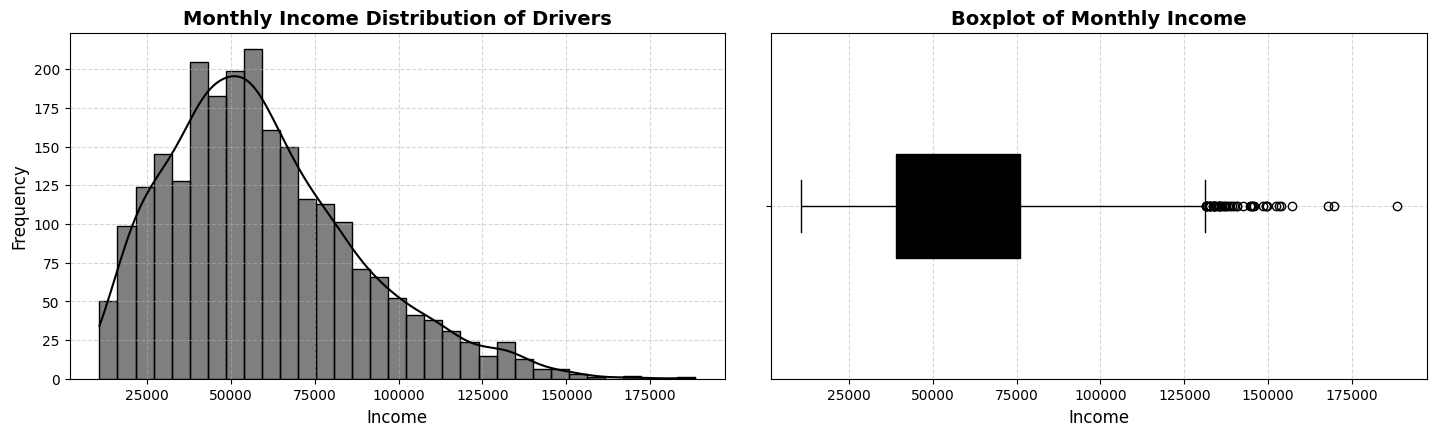

In [51]:
# Set figure size
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram with KDE
sns.histplot(final_data['Income'], color='black', kde=True, ax=axes[0])
axes[0].set_title("Monthly Income Distribution of Drivers", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Income", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.5)

# Boxplot
sns.boxplot(x=final_data['Income'], ax=axes[1], color='black', width=0.3)
axes[1].set_title("Boxplot of Monthly Income", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Income", fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.5)

# Adjust layout
plt.tight_layout(pad=3)
plt.show()

# Inference
- The distribution of monthly income skewed on right which might indicate the outliers in the data

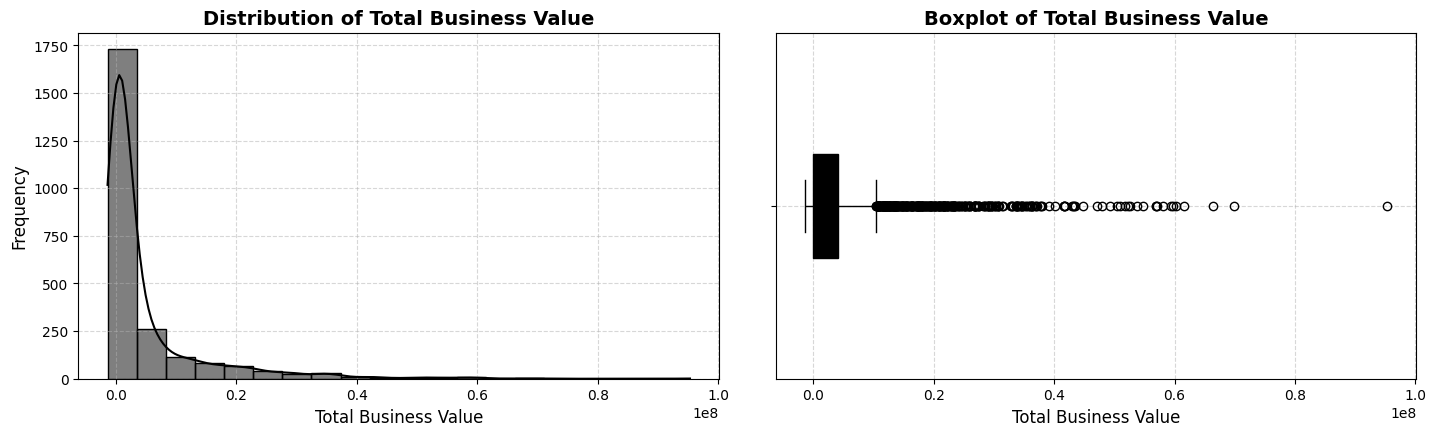

In [52]:
# Set figure size
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram with KDE
sns.histplot(final_data['Total_Business_Value'], color='black', kde=True, bins=20, ax=axes[0])
axes[0].set_title("Distribution of Total Business Value", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Total Business Value", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.5)

# Boxplot
sns.boxplot(x=final_data['Total_Business_Value'], ax=axes[1], color='black', width=0.3)
axes[1].set_title("Boxplot of Total Business Value", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Total Business Value", fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.5)

# Adjust layout
plt.tight_layout(pad=3)
plt.show()

# Inference
- The distribution of total business value highly skewed on right which might indicate the outliers in the data

# Bi-Variate Analysis

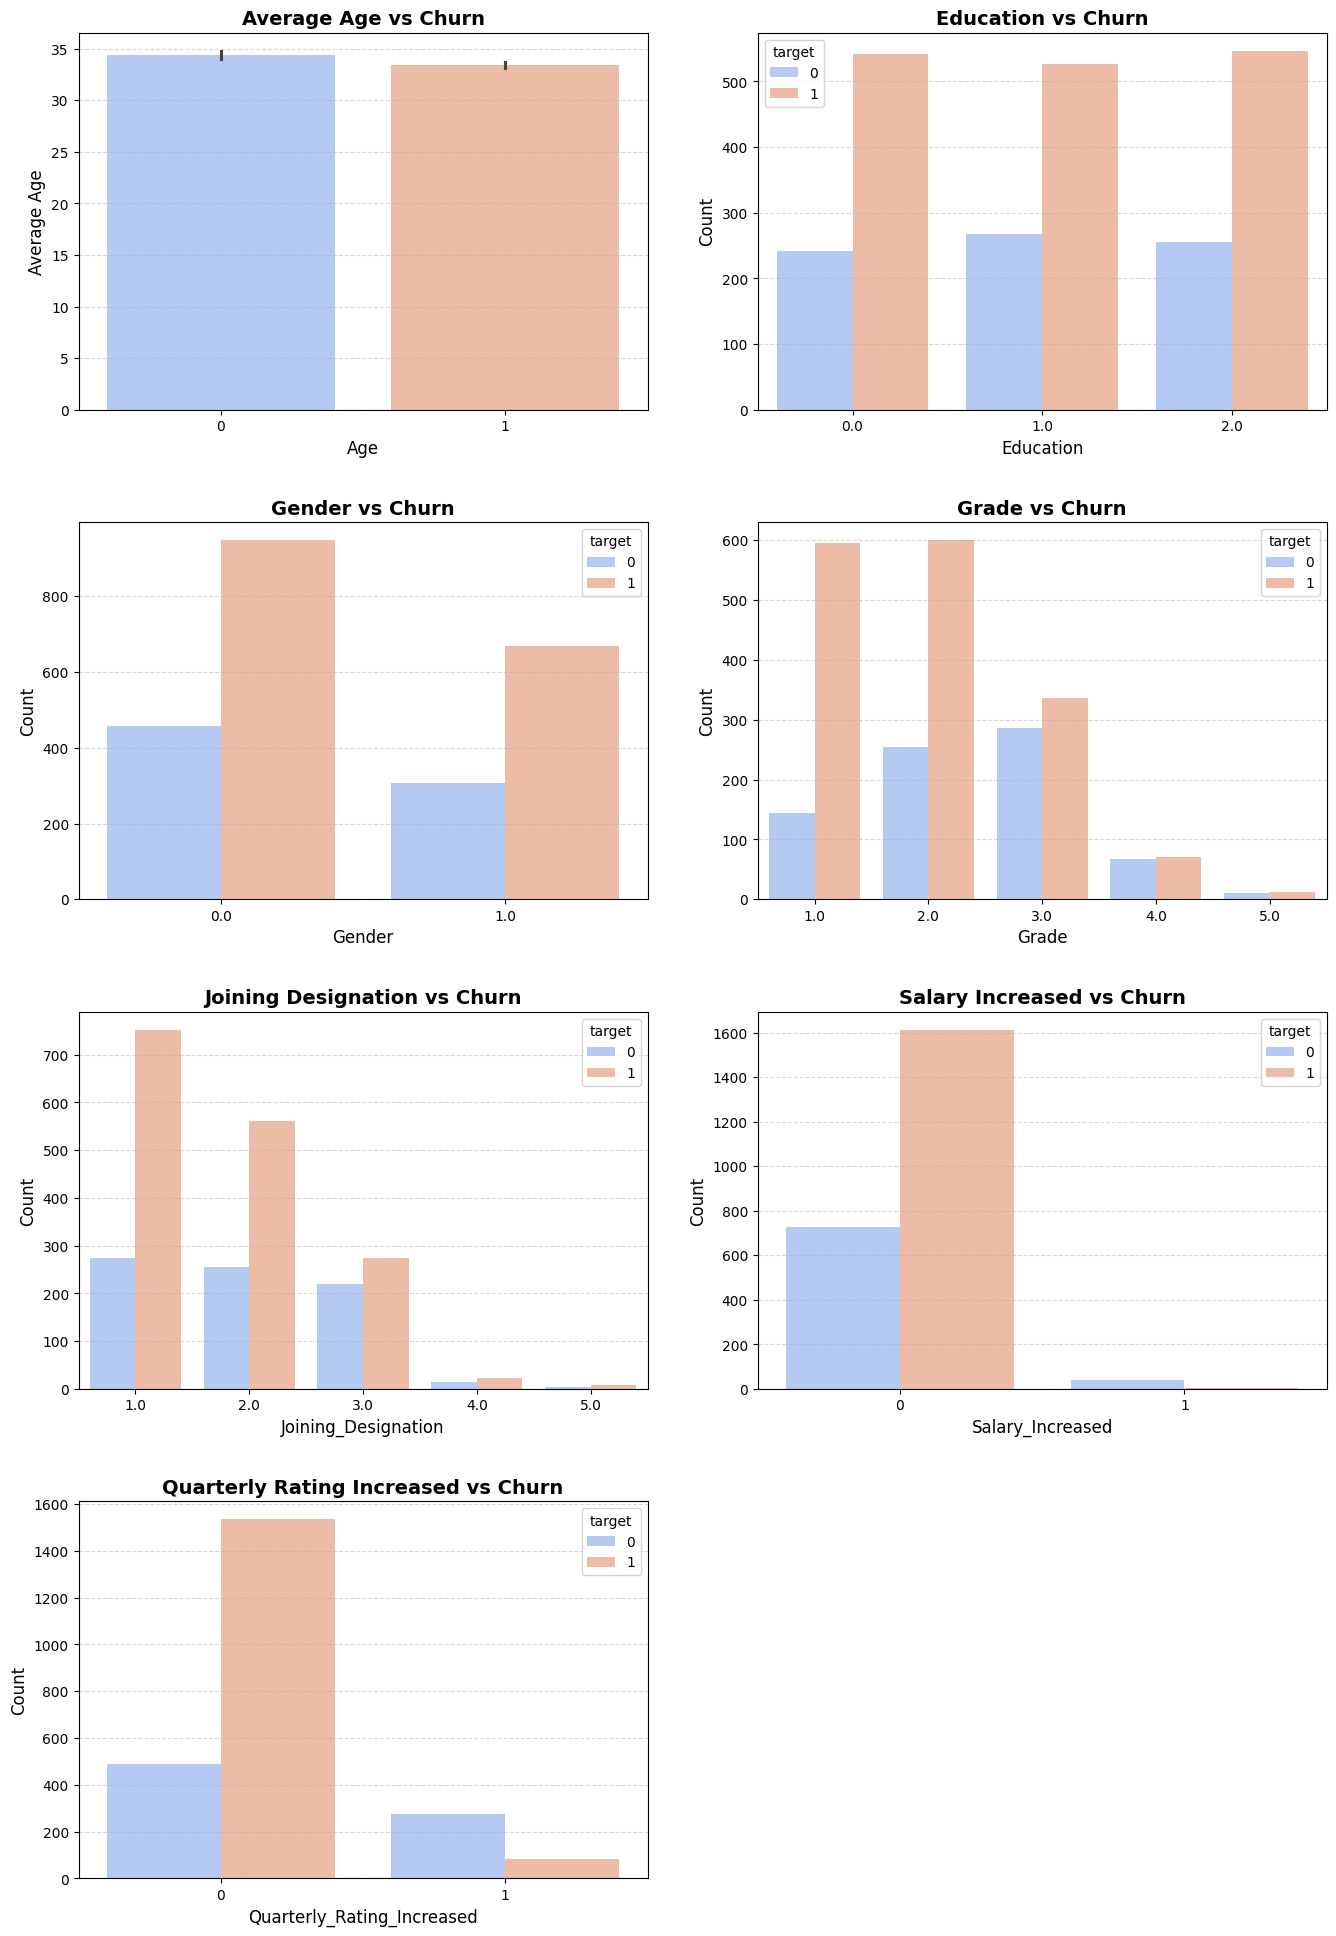

In [53]:
# Set figure size
fig, axes = plt.subplots(4, 2, figsize=(14, 20))  # 4 rows, 2 columns

# Define feature list for iteration
features = ["Age", "Education", "Gender", "Grade", "Joining_Designation", "Salary_Increased", "Quarterly_Rating_Increased"]
titles = ["Average Age vs Churn", "Education vs Churn", "Gender vs Churn", "Grade vs Churn",
          "Joining Designation vs Churn", "Salary Increased vs Churn", "Quarterly Rating Increased vs Churn"]

# Plot each feature
for i, (feature, title) in enumerate(zip(features, titles)):
    row, col = divmod(i, 2)  # Determine row and column positions

    if feature == "Age":
        # Use barplot to show avg Age for churn vs. non-churn
        sns.barplot(data=final_data, x="target", y=feature, ax=axes[row, col], palette="coolwarm")
        axes[row, col].set_ylabel("Average Age", fontsize=12)
    else:
        # Use countplot for categorical features
        sns.countplot(data=final_data, x=feature, hue="target", ax=axes[row, col], palette="coolwarm")
        axes[row, col].set_ylabel("Count", fontsize=12)

    axes[row, col].set_title(title, fontsize=14, fontweight='bold')
    axes[row, col].set_xlabel(feature, fontsize=12)
    axes[row, col].grid(axis="y", linestyle="--", alpha=0.5)

# Hide the empty subplot (if any)
if len(features) % 2 != 0:
    fig.delaxes(axes[-1, -1])

# Adjust layout
plt.tight_layout(pad=3)
plt.show()

# Inference
- The proportion of Age, gender and education is more or less the same for both the employees who left the organization and those who did not leave.
- Joining designation 1,2 has more probability to churn than 3,4
- The employees who have their grade as 3 or 4 at the time of joining are less likely to leave the organization.
- The employees whose quarterly rating has increased are less likely to leave the organization.
- The employees whose monthly salary has not increased are more likely to leave the organization.

# Correlation Analysis

In [54]:
final_data.head()

,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,target,Salary_Increased
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,0,1,0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,0,0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,0,1,0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,0,1,0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,1,0,0


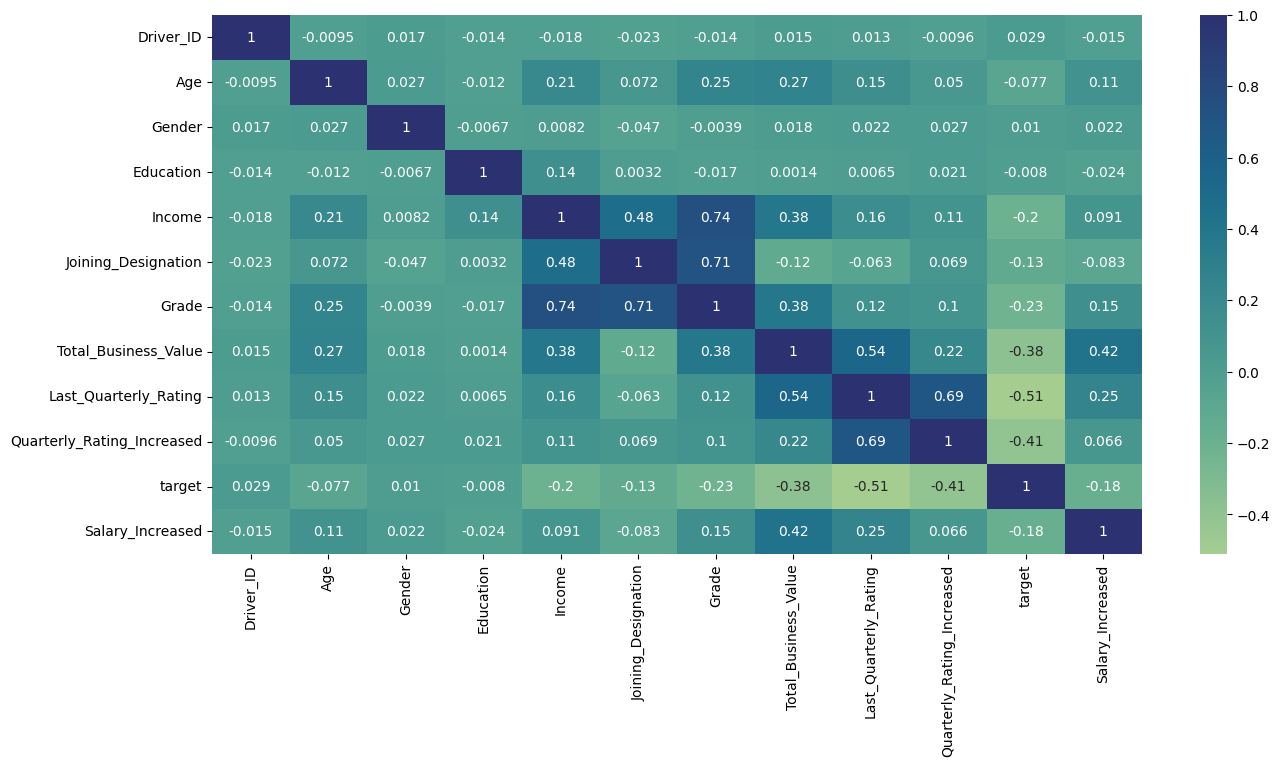

In [55]:
plt.figure(figsize=(15, 7))

sns.heatmap(final_data.drop(columns=['City']).corr(method="pearson"), annot=True, cmap="crest")
plt.show()

# Inference
- Income and Grade is highly correlated
- Joining Designation and Grade is highly correlated
- Total Business value and salary increased is correlated

In [56]:
final_data.shape

(2381, 13)

# Standardization (for training data)

In [113]:
X = final_data.drop(["Driver_ID", "target", "City"], axis = 1)
X_cols = X.columns
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [114]:
X_scaled = pd.DataFrame(X_scaled)

X_scaled.columns = X_cols

X_scaled.head()

,Age,Gender,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,Salary_Increased
0,-0.962809,-0.833464,1.216049,-0.068616,-0.975022,-1.164953,-0.314641,0.706497,-0.420672,-0.135616
1,-0.459232,-0.833464,1.216049,0.270700,0.213676,-0.102619,-0.502646,-0.528576,-0.420672,-0.135616
2,1.555073,-0.833464,1.216049,0.220907,0.213676,-0.102619,-0.464290,-0.528576,-0.420672,-0.135616
3,-0.794950,-0.833464,-1.234575,-0.456914,-0.975022,-1.164953,-0.489456,-0.528576,-0.420672,-0.135616
4,-0.459232,1.199812,-0.009263,0.683418,1.402374,0.959714,-0.364019,0.706497,2.377149,-0.135616


# Train & Test Split

In [115]:
y = final_data["target"]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7, shuffle=True)

In [116]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (1904, 10)
X_test Shape:  (477, 10)
y_train Shape:  (1904,)
y_test Shape:  (477,)


# Logistic Regression

In [61]:
params = {
    "class_weight": [{0: 2.0, 1: 0.8},{0: 1.6, 1: 0.8},{0: 1.2, 1: 0.8}],
    "C" : [0.8,1,1.2]
}

lr = LogisticRegression()
c = GridSearchCV(estimator=lr, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params:  {'C': 0.8, 'class_weight': {0: 1.2, 1: 0.8}}
Best Score:  0.8607684304605684


              precision    recall  f1-score   support

           0       0.73      0.55      0.63       148
           1       0.82      0.91      0.86       329

    accuracy                           0.80       477
   macro avg       0.78      0.73      0.75       477
weighted avg       0.79      0.80      0.79       477



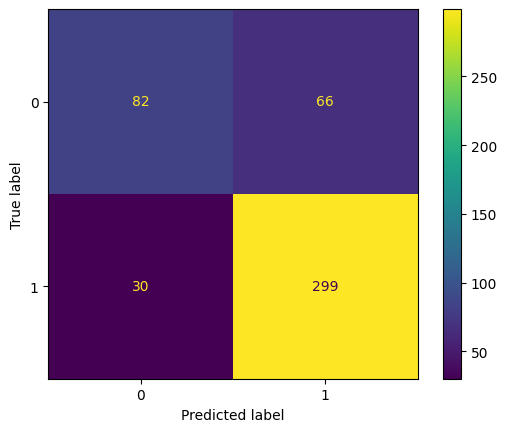

In [62]:
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

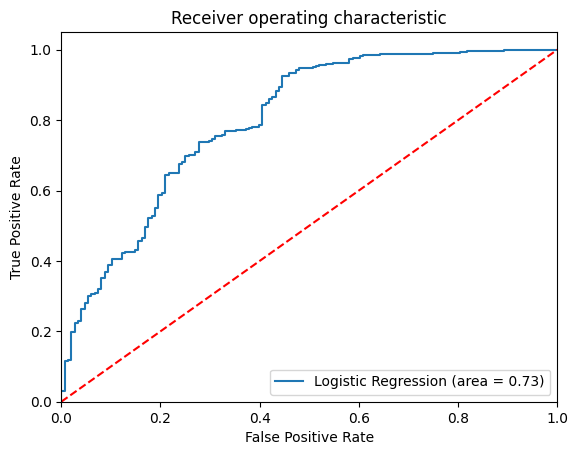

In [63]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Random Forest Classifier

In [64]:
params = {
    "max_depth": [2, 3, 4, 6],
    "n_estimators": [20, 50, 100, 150],
    "class_weight": [{0: 2.0, 1: 0.8},{0: 1.6, 1: 0.8},{0: 1.2, 1: 0.8}]
}

start_time = time.time()
random_forest = RandomForestClassifier()
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Params:  {'class_weight': {0: 1.2, 1: 0.8}, 'max_depth': 6, 'n_estimators': 50}
Best Score:  0.8691149868453015

Elapsed Time:  42.91552710533142


              precision    recall  f1-score   support

           0       0.77      0.57      0.65       148
           1       0.83      0.92      0.87       329

    accuracy                           0.81       477
   macro avg       0.80      0.75      0.76       477
weighted avg       0.81      0.81      0.80       477



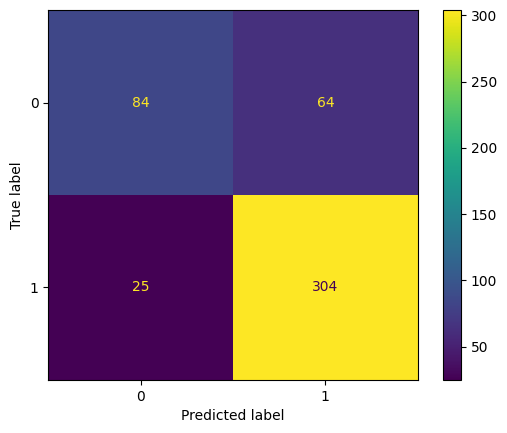

In [65]:
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

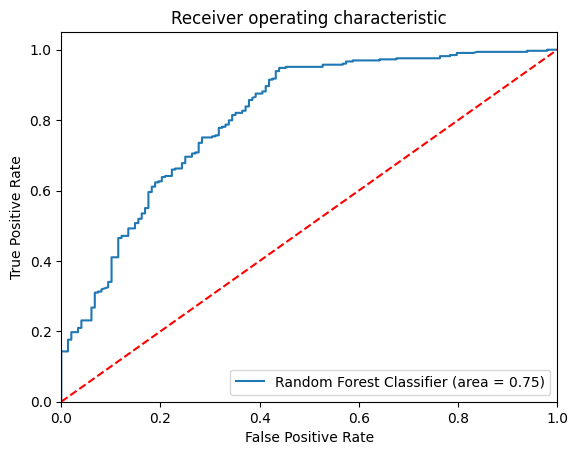

In [66]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**There is not much significant difference in the matrices observed for Random Forest and Logistic Regression**

Reason could be :
- Our data may be linearly seperable in features and we don't need to consider some extra feature interactions in between.

# Gradient Boosted DT Classifier

In [73]:
class_weight = [{0: 2.0, 1: 0.8},{0: 1.6, 1: 0.8},{0: 1.2, 1: 0.8}]
scale_pos_weight = []
# scale_pos_weight = count_negative_examples / count_positive_examples

for cw in class_weight:
  scale_pos_weight.append(round(cw[0]/cw[1],2))

X_train_,X_train_cv,y_train_,y_train_cv = train_test_split(X_train,y_train,test_size=0.25,random_state=7,shuffle=True)

In [81]:
scale_pos_weight

[2.5, 2.0, 1.5]

In [85]:
# Lists to store results
train_scores = []
cv_scores = []
train_losses = []
cv_losses = []
param_combinations = []

# Hyperparameters to tune
learning_rate = [0.1, 0.5, 0.8]
subsample = [0.6, 0.8, 1.0]
colsample_bytree = [0.6, 0.8, 1.0]
max_depth = [3, 4, 5]
scale_pos_weight = [1.0, 1.5, 2.0]

# Nested loops to iterate over all combinations
for lr in learning_rate:
    for ss in subsample:
        for cs_bytree in colsample_bytree:
            for md in max_depth:
                for spw in scale_pos_weight:
                    # Save the parameter combination
                    param_combinations.append((lr, ss, cs_bytree, md, spw))

                    # Initialize and train the model
                    model = xgb.XGBClassifier(
                        learning_rate=lr,
                        subsample=ss,
                        colsample_bytree=cs_bytree,
                        max_depth=md,
                        scale_pos_weight=spw,
                        random_state=42,
                        use_label_encoder=False,
                        eval_metric="logloss"
                    )
                    model.fit(X_train_, y_train_)

                    # Predict on the training set
                    y_train_pred = model.predict(X_train_)
                    y_train_pred_proba = model.predict_proba(X_train_)

                    train_f1 = f1_score(y_train_, y_train_pred, average='weighted')
                    train_loss = log_loss(y_train_, y_train_pred_proba)

                    train_scores.append(train_f1)
                    train_losses.append(train_loss)

                    # Predict on the cross-validation set
                    y_cv_pred = model.predict(X_train_cv)
                    y_cv_pred_proba = model.predict_proba(X_train_cv)

                    cv_f1 = f1_score(y_train_cv, y_cv_pred, average='weighted')
                    cv_loss = log_loss(y_train_cv, y_cv_pred_proba)

                    cv_scores.append(cv_f1)
                    cv_losses.append(cv_loss)

# Print results
for params, train_f1, cv_f1, train_loss, cv_loss in zip(param_combinations, train_scores, cv_scores, train_losses, cv_losses):
    lr, ss, cs_bytree, md, spw = params
    print(f"Learning Rate: {lr} | Subsample: {ss} | Colsample_bytree: {cs_bytree} | Max_depth: {md} | Scale Pos Weight: {spw} | "
          f"Train F1: {train_f1:.4f} | CV F1: {cv_f1:.4f} | Train Loss: {train_loss:.4f} | CV Loss: {cv_loss:.4f}")


Learning Rate: 0.1 | Subsample: 0.6 | Colsample_bytree: 0.6 | Max_depth: 3 | Scale Pos Weight: 1.0 | Train F1: 0.8258 | CV F1: 0.8196 | Train Loss: 0.3697 | CV Loss: 0.4210
Learning Rate: 0.1 | Subsample: 0.6 | Colsample_bytree: 0.6 | Max_depth: 3 | Scale Pos Weight: 1.5 | Train F1: 0.8219 | CV F1: 0.8091 | Train Loss: 0.3759 | CV Loss: 0.4230
Learning Rate: 0.1 | Subsample: 0.6 | Colsample_bytree: 0.6 | Max_depth: 3 | Scale Pos Weight: 2.0 | Train F1: 0.8128 | CV F1: 0.8012 | Train Loss: 0.3901 | CV Loss: 0.4304
Learning Rate: 0.1 | Subsample: 0.6 | Colsample_bytree: 0.6 | Max_depth: 4 | Scale Pos Weight: 1.0 | Train F1: 0.8551 | CV F1: 0.8153 | Train Loss: 0.3296 | CV Loss: 0.4169
Learning Rate: 0.1 | Subsample: 0.6 | Colsample_bytree: 0.6 | Max_depth: 4 | Scale Pos Weight: 1.5 | Train F1: 0.8431 | CV F1: 0.8164 | Train Loss: 0.3340 | CV Loss: 0.4183
Learning Rate: 0.1 | Subsample: 0.6 | Colsample_bytree: 0.6 | Max_depth: 4 | Scale Pos Weight: 2.0 | Train F1: 0.8341 | CV F1: 0.8018 |

In [89]:
print("Best Hyperparams")
print("Learning Rate: 0.1 | Subsample: 0.8 | Colsample_bytree: 1.0 | Max_depth: 5 | Scale Pos Weight: 1.0 | Train F1: 0.9043 | CV F1: 0.8261 | Train Loss: 0.2605 | CV Loss: 0.4356")

Best Hyperparams
Learning Rate: 0.1 | Subsample: 0.8 | Colsample_bytree: 1.0 | Max_depth: 5 | Scale Pos Weight: 1.0 | Train F1: 0.9043 | CV F1: 0.8261 | Train Loss: 0.2605 | CV Loss: 0.4356


In [91]:
lr = 0.1
ss = 0.8
cs_bytree = 1.0
md = 5
spw = 1.0

# Initialize and train the model
model = xgb.XGBClassifier(
                        learning_rate=lr,
                        subsample=ss,
                        colsample_bytree=cs_bytree,
                        max_depth=md,
                        scale_pos_weight=spw,
                        random_state=42,
                        use_label_encoder=False,
                        eval_metric="logloss"
                    )
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.70      0.53      0.61       148
           1       0.81      0.90      0.85       329

    accuracy                           0.78       477
   macro avg       0.75      0.72      0.73       477
weighted avg       0.78      0.78      0.78       477



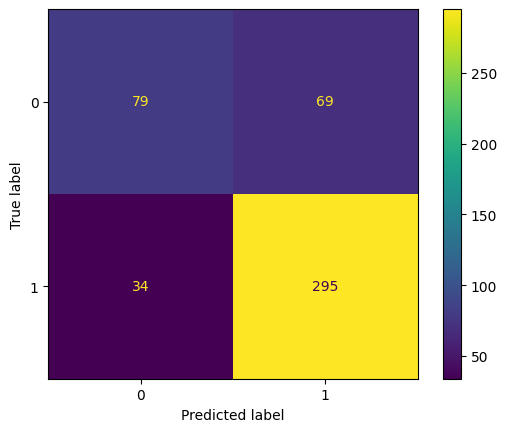

In [92]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

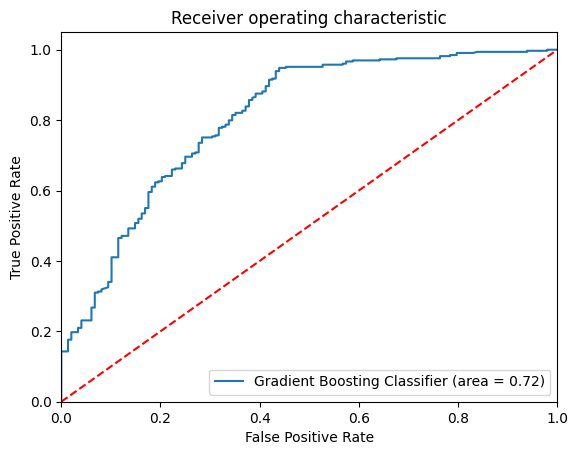

In [93]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Gradient Boosting Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importance of the best model so far.

**Random Forest Classifier outperforms the rest of the model.**

**Best parameters**

Best Params:  {'class_weight': {0: 1.2, 1: 0.8}, 'max_depth': 6, 'n_estimators': 50}


In [94]:
rf = RandomForestClassifier(max_depth = 6, n_estimators= 50, class_weight={0: 1.2, 1: 0.8})

rf.fit(X_train, y_train)
print("Score of RandomForestClassifier: ", rf.score(X_test, y_test))


Score of RandomForestClassifier:  0.8092243186582809


              precision    recall  f1-score   support

           0       0.77      0.57      0.65       148
           1       0.83      0.92      0.87       329

    accuracy                           0.81       477
   macro avg       0.80      0.75      0.76       477
weighted avg       0.81      0.81      0.80       477



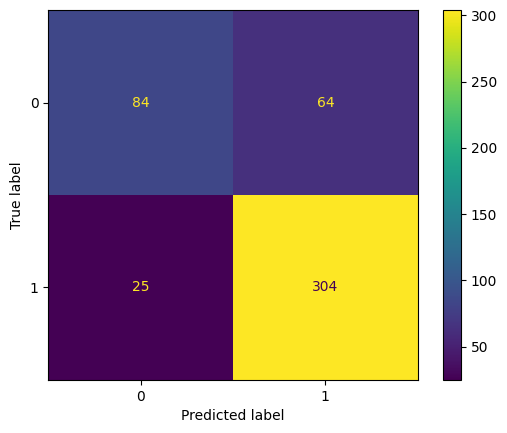

In [104]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_).plot()

In [95]:
importances = rf.feature_importances_
importances

array([0.04751719, 0.00687584, 0.01067119, 0.07624023, 0.06018005,
       0.05619293, 0.28920829, 0.2837932 , 0.15996745, 0.00935365])

In [96]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

<Figure size 1500x700 with 0 Axes>

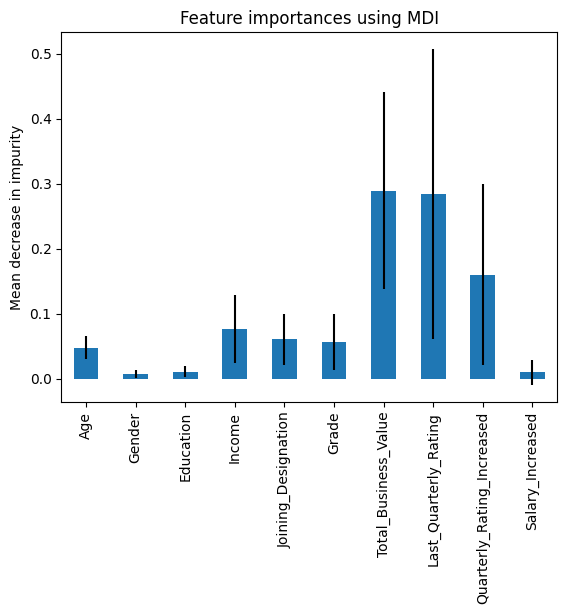

In [97]:
feature_importances = pd.Series(importances, X_train.columns)

plt.figure(figsize=(15,7))
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

plt.show()

**Insights**
- Last_Quarterly_Rating, Total_Business_Value & Quarterly_Rating_Increased are the most important features.

# Actionable Insights and Recommendation

- Out of 2381 drivers 1616 have left the company.
- We need to incentivise the drivers overtime or other perks to overcome churning
- The employees whose quarterly rating has increased are less likely to leave the organization.
- Company needs to implement the reward system for the customer who provide the feedback and rate drivers
- The employees whose monthly salary has not increased are more likely to leave the organization.
- Company needs to get in touch with those drivers whose monthly salary has not increased and help them out to earn more by provider bonus and perks.
- Out of 2381 employees, 1744 employees had their last quarterly rating as 1.
- Out of 2381 employees, the quarterly rating has not increased for 2023 employees. This is red flag for the company which needs to regulate.
- Company needs to look why customers are not rating drivers.
- Last_Quarterly_Rating, Total_Business_Value & Quarterly_Rating_Increased are the most important features. Company needs to tracks these features as predicators
- We observe that we are not getting very high recall on target 0 which may be due to small imbalanced dataset. More data will overcome this issue.
- The Random Forest Classifier attains the Recall score of 92% for the driver who left the company. Which indicates that model is performing the decent job.

# For the Deployement Purpose

In [118]:
import joblib
from google.colab import files

joblib.dump(scaler, '/content/scaler.pkl')
joblib.dump(rf, '/content/rf_model.pkl')

['/content/rf_model.pkl']

In [119]:
from google.colab import files

# Download the scaler and model
files.download('/content/scaler.pkl')
files.download('/content/rf_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [121]:
pip freeze>requirements.txt

In [122]:
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>